In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math

from pandas import Series, DataFrame 
from scipy.optimize import minimize
from scipy import integrate
from scipy import stats

%matplotlib inline

RANDOM_STATE = 42

# Предобработка датасета

In [2]:
anime = pd.read_csv("anime.csv")
anime.head()

,title,mediaType,eps,duration,ongoing,startYr,finishYr,sznOfRelease,description,studios,tags,contentWarn,watched,watching,wantWatch,dropped,rating,votes
0,Fullmetal Alchemist: Brotherhood,TV,64.0,NaN,False,2009.0,2010.0,Spring,The foundation of alchemy is based on the law ...,['Bones'],"['Action', 'Adventure', 'Drama', 'Fantasy', 'M...","['Animal Abuse', 'Mature Themes', 'Violence', ...",103707.0,14351,25810,2656,4.702,86547.0
1,your name.,Movie,1.0,107.0,False,2016.0,2016.0,NaN,Mitsuha and Taki are two total strangers livin...,['CoMix Wave Films'],"['Drama', 'Romance', 'Body Swapping', 'Gender ...",[],58831.0,1453,21733,124,4.663,43960.0
2,A Silent Voice,Movie,1.0,130.0,False,2016.0,2016.0,NaN,"After transferring into a new school, a deaf g...",['Kyoto Animation'],"['Drama', 'Shounen', 'Disability', 'Melancholy...","['Bullying', 'Mature Themes', 'Suicide']",45892.0,946,17148,132,4.661,33752.0
3,Haikyuu!! Karasuno High School vs Shiratorizaw...,TV,10.0,NaN,False,2016.0,2016.0,Fall,"Picking up where the second season ended, the ...",['Production I.G'],"['Shounen', 'Sports', 'Animeism', 'School Club...",[],25134.0,2183,8082,167,4.660,17422.0
4,Attack on Titan 3rd Season: Part II,TV,10.0,NaN,False,2019.0,2019.0,Spring,The battle to retake Wall Maria begins now! Wi...,['Wit Studio'],"['Action', 'Fantasy', 'Horror', 'Shounen', 'Da...","['Cannibalism', 'Explicit Violence']",21308.0,3217,7864,174,4.650,15789.0


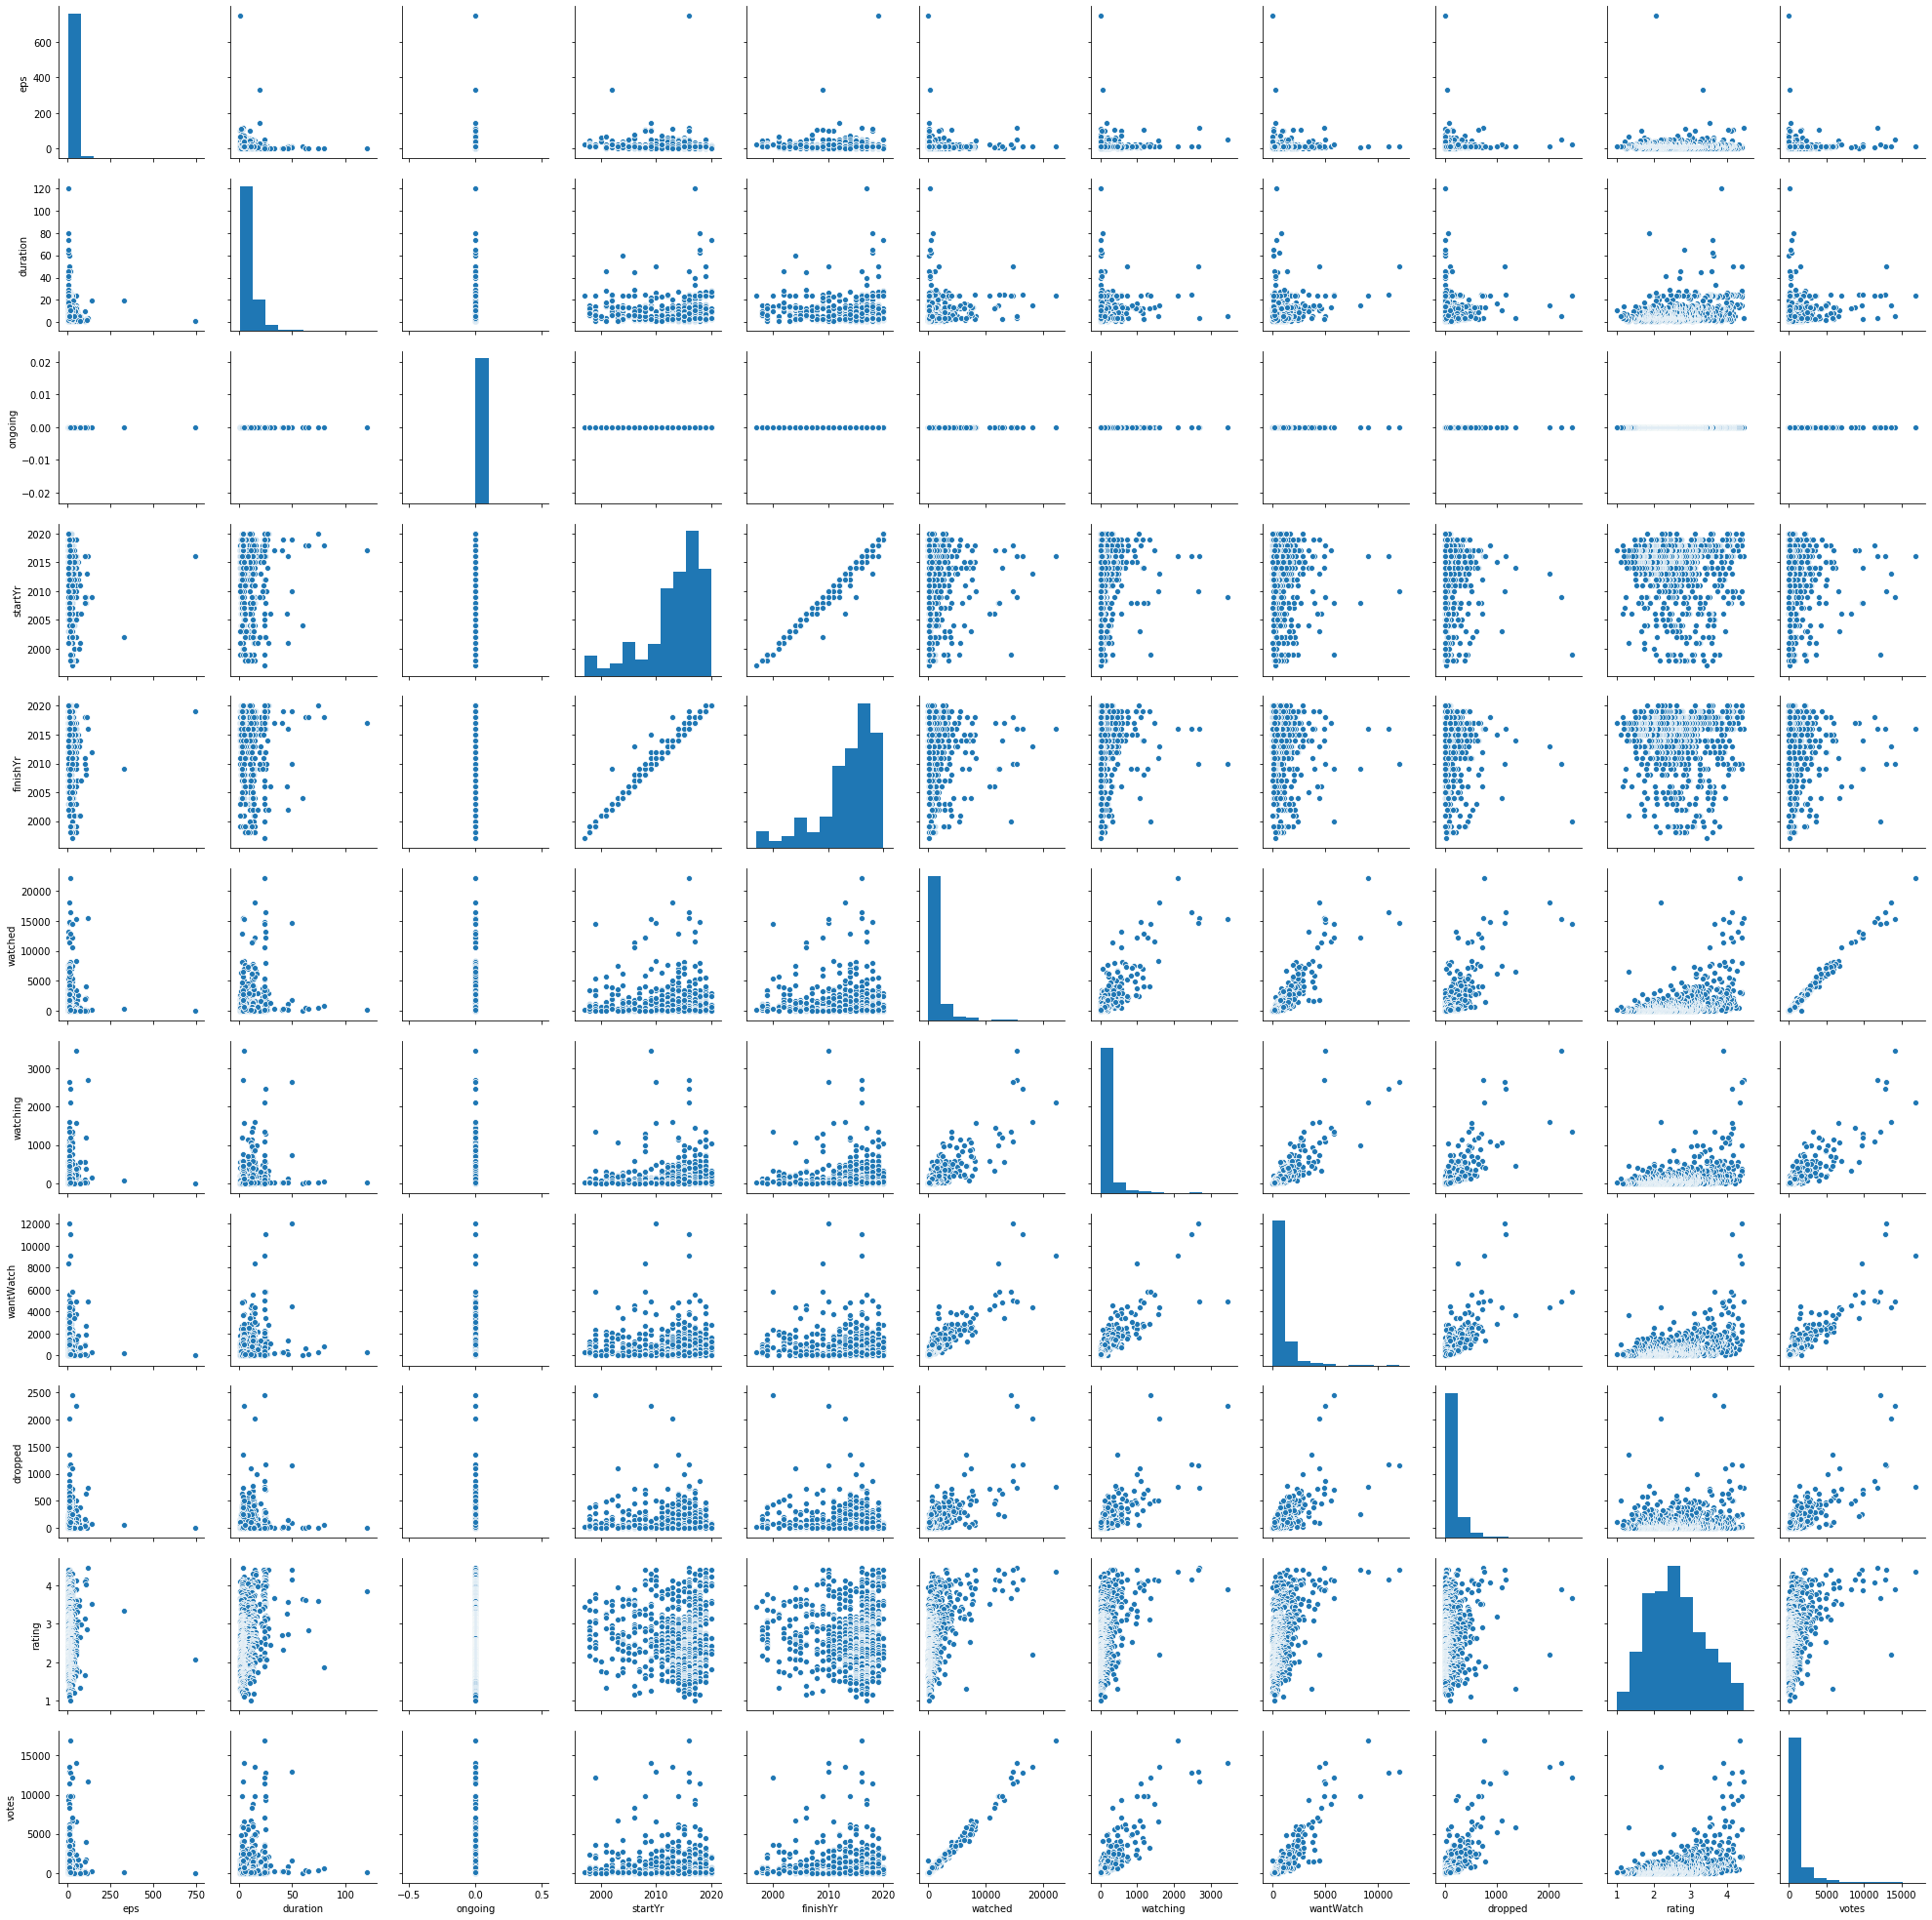

In [3]:
sns_plot = sns.pairplot(anime[anime.columns].dropna())

In [4]:
unnesessary = ['title', 'mediaType', 'eps', 'duration', 'ongoing', 'startYr',
       'finishYr', 'sznOfRelease', 'description', 'studios', 'tags',
       'contentWarn', 'watched', 'watching', 'dropped',
       'votes']
data = anime.copy(deep=True)
data = data.drop(unnesessary, axis=1)
data.head()

,wantWatch,rating
0,25810,4.702
1,21733,4.663
2,17148,4.661
3,8082,4.660
4,7864,4.650


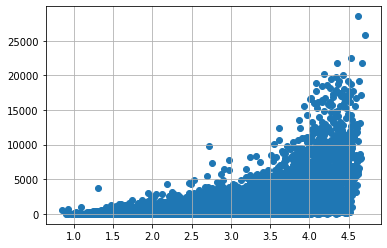

In [5]:
plt.scatter(data['rating'], data['wantWatch'])
plt.grid()

In [6]:
def find_NaN(df):
    nans = df.loc[:, df.isnull().any()].copy()
    print(nans.columns)
    nans = nans.isna().sum()
    print(nans)

In [7]:
find_NaN(data)

Index(['rating'], dtype='object')
rating    2471
dtype: int64


In [8]:
data = data.dropna(axis='index', how='any')
find_NaN(data)

Index([], dtype='object')
Series([], dtype: float64)


In [9]:
data.shape

(12107, 2)

# Поиск степени МНК

In [10]:
def MNK(df, m):
    if m < 0:
        raise Exception("m must be >= 0")
    Y = np.array(df['wantWatch'])
    X = np.array(df['rating'])
    H = []
    for i in range(m + 1):
        H.append(X ** i)
    H = np.array(H).T
    O = (np.linalg.inv(H.T.dot(H)).dot(H.T)).dot(Y)
    return O

def fMNK(O):
    return lambda x: sum([O[i] * x ** i for i in range(len(O))])

In [11]:
def _Y(df, O):
    f = fMNK(O)
    X = np.array(df['rating'])
    return np.array([f(x_) for x_ in X])

def _E(df, O):
    Y = np.array(df['wantWatch'])
    _y = _Y(df, O)
    return [Y[i] - _y[i] for i in range(len(Y))]

def Y_mean(Y):    
    return sum(Y) / len(Y)

def R(df, O):
    Y = np.array(df['wantWatch'])
    E = _E(df, O)
    Y_ = Y_mean(Y)
    R = 1 - sum([e * e for e in E]) / sum([(y - Y_) ** 2 for y in Y])
    return R

def graphic(df, O):
    fig = plt.figure(figsize=(10, 10))
    plt.grid()
    plt.scatter(df['rating'], df['wantWatch'])
    f = fMNK(O)
    x = np.arange(0, 5.01, 0.01)
    y = [f(x_) for x_ in x]
    plt.plot(x, y, color="red")

## m = 0

O = [1203.1203436]
R = 2.220446049250313e-16


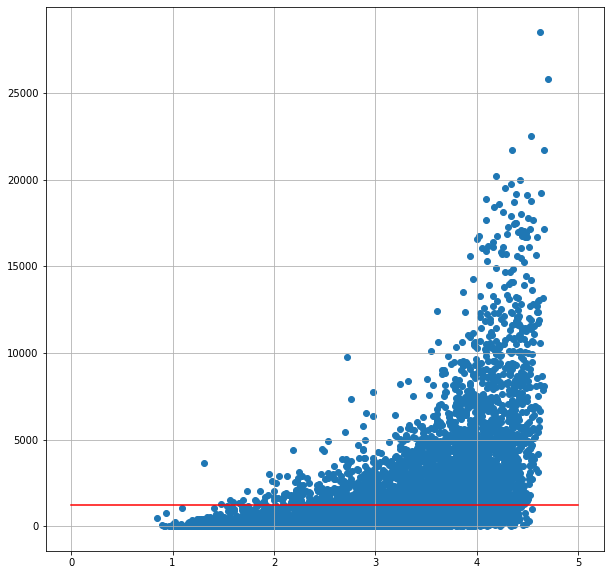

In [12]:
m = 0
O = MNK(data, m)

print("O = {}".format(O))
print("R = {}".format(R(data, O)))
graphic(data, O)

## m = 1

O = [-3111.15176414  1463.11147582]
R = 0.2786706237663563


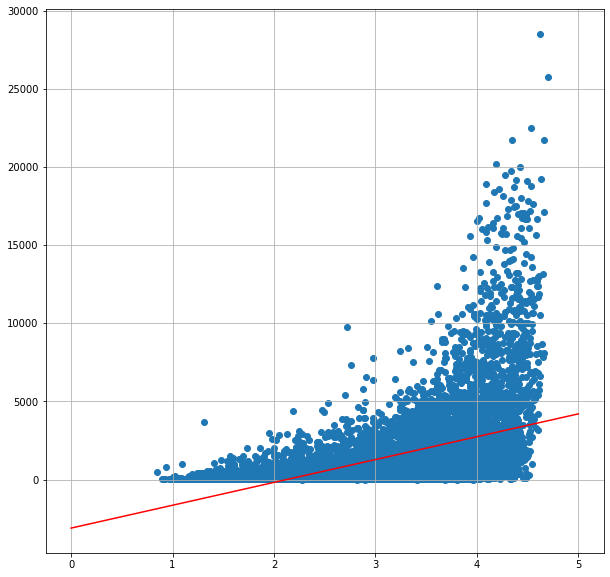

In [13]:
m = 1
O = MNK(data, m)

print("O = {}".format(O))
print("R = {}".format(R(data, O)))
graphic(data, O)

## m = 2

O = [ 5241.36489557 -4786.06352903  1074.0594016 ]
R = 0.3919132544396259


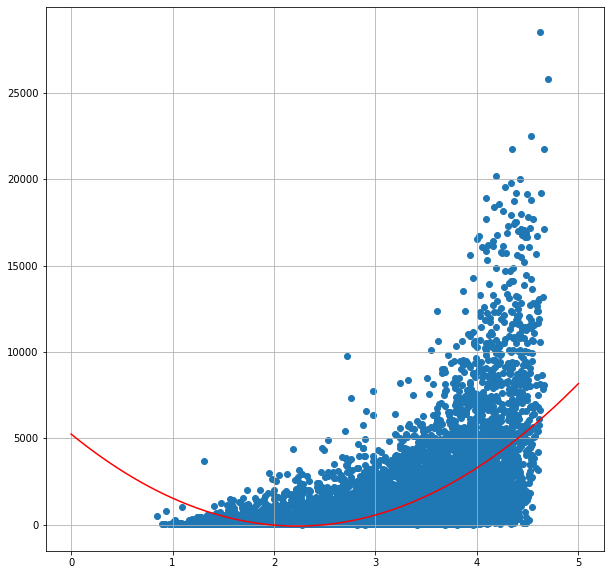

In [14]:
m = 2
O = MNK(data, m)

print("O = {}".format(O))
print("R = {}".format(R(data, O)))
graphic(data, O)

## m = 3

O = [-7127.08320738  9921.85038896 -4349.30635515   627.91022959]
R = 0.42371269887281204


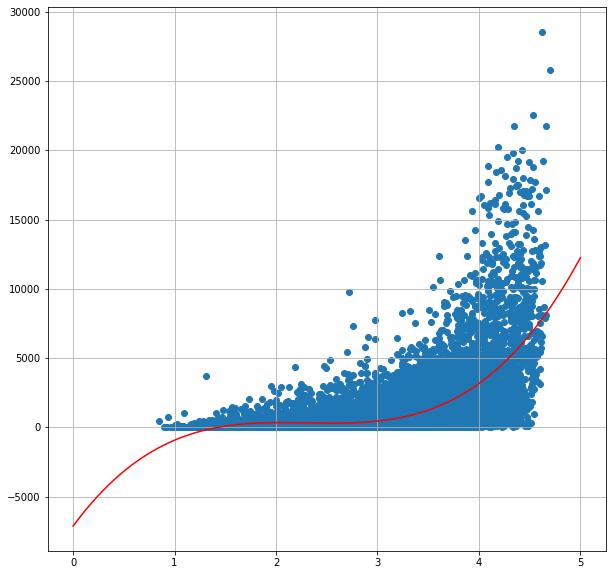

In [15]:
m = 3
O = MNK(data, m)

print("O = {}".format(O))
print("R = {}".format(R(data, O)))
graphic(data, O)

## m = 4

O = [  8943.67198229 -16660.0204526   11127.26506966  -3161.70488665
    331.83469819]
R = 0.43152359857772515


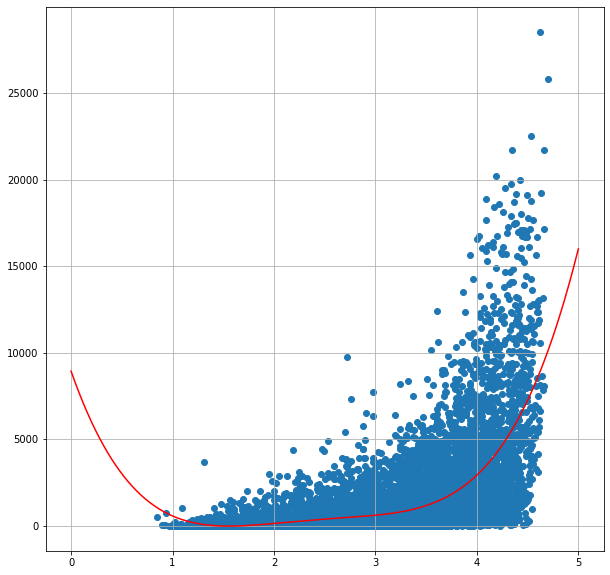

In [16]:
m = 4
O = MNK(data, m)

print("O = {}".format(O))
print("R = {}".format(R(data, O)))
graphic(data, O)

## m = 5

O = [-12751.52889295  29733.24297862 -26359.21949074  11227.35197352
  -2307.29077783    186.03949173]
R = 0.4337236112369487


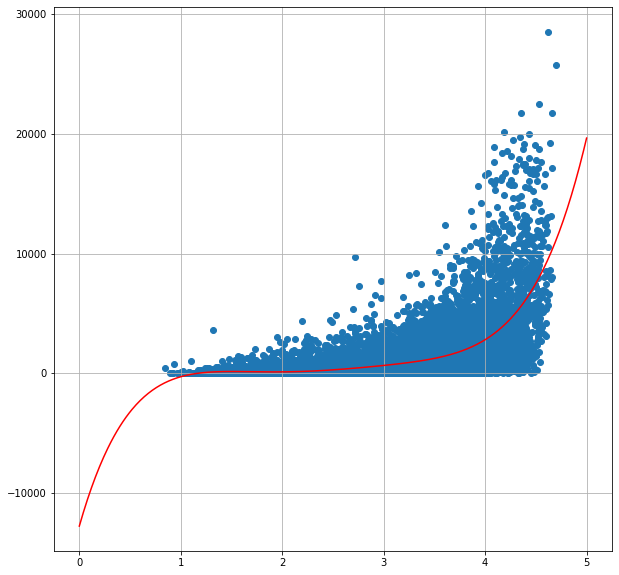

In [17]:
m = 5
O = MNK(data, m)

print("O = {}".format(O))
print("R = {}".format(R(data, O)))
graphic(data, O)

## m = 6

O = [ 32854.44149792 -90219.00197849  98486.23172437 -54876.98847569
  16557.96020906  -2577.2681799     162.95047433]
R = 0.43526314401931987


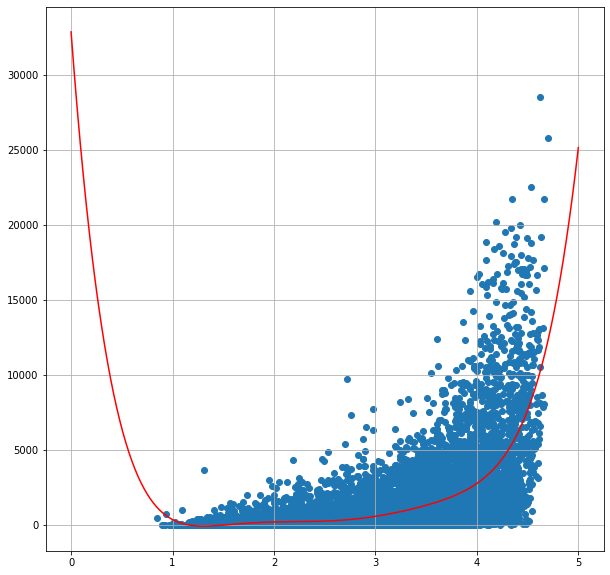

In [18]:
m = 6
O = MNK(data, m)

print("O = {}".format(O))
print("R = {}".format(R(data, O)))
graphic(data, O)

## m = 7

O = [-7.66379882e+04  2.51985480e+05 -3.38924924e+05  2.42529472e+05
 -1.00017176e+05  2.38563127e+04 -3.05814934e+03  1.63218302e+02]
R = 0.4367011213377726


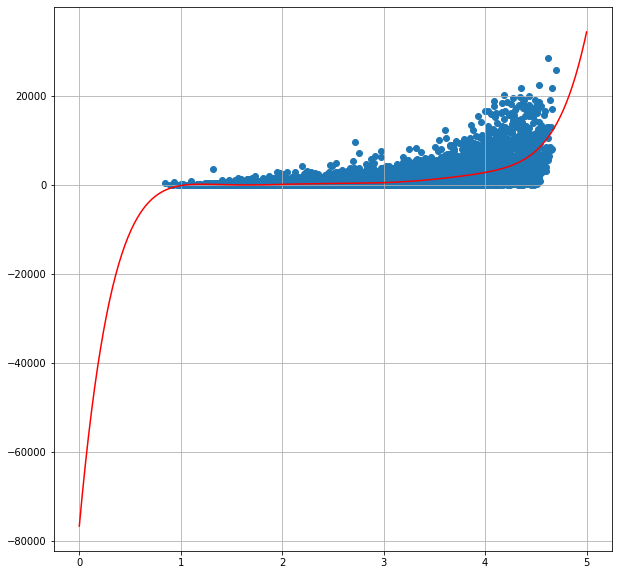

In [19]:
m = 7
O = MNK(data, m)

print("O = {}".format(O))
print("R = {}".format(R(data, O)))
graphic(data, O)

## m = 8

O = [ 1.61368762e+05 -6.11747710e+05  9.75224607e+05 -8.55086922e+05
  4.51915185e+05 -1.47715426e+05  2.92269395e+04 -3.20773372e+03
  1.49884110e+02]
R = 0.43785058828474754


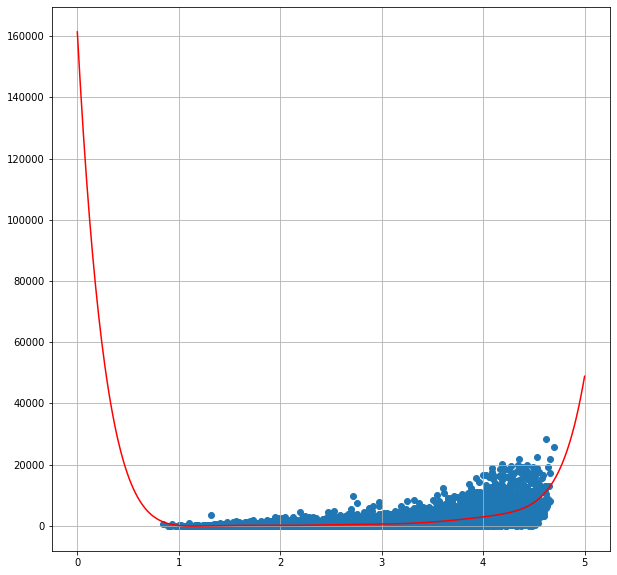

In [20]:
m = 8
O = MNK(data, m)

print("O = {}".format(O))
print("R = {}".format(R(data, O)))
graphic(data, O)

## m = 9

O = [-1.88742359e+05  8.38708695e+05 -1.59302839e+06  1.70036372e+06
 -1.12611022e+06  4.80837290e+05 -1.32628139e+05  2.28313053e+04
 -2.22995009e+03  9.43284813e+01]
R = 0.4380769816780895


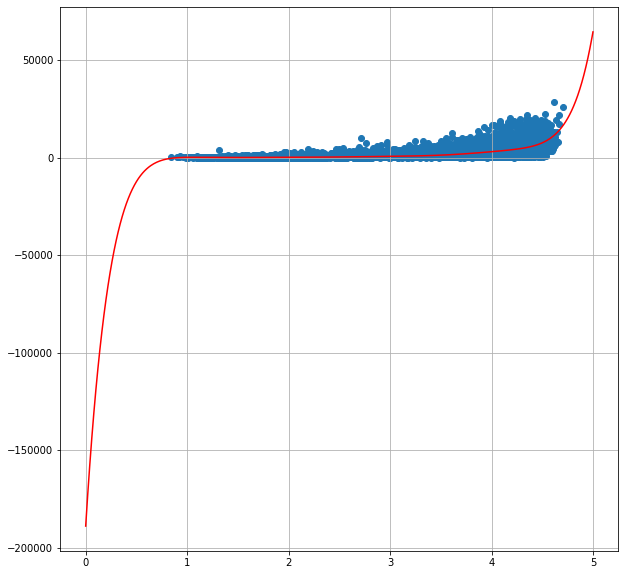

In [21]:
m = 9
O = MNK(data, m)

print("O = {}".format(O))
print("R = {}".format(R(data, O)))
graphic(data, O)

## m = 10

O = [-3.24722916e+05  1.47052753e+06 -2.85620822e+06  3.14558255e+06
 -2.17591080e+06  9.87685675e+05 -2.97673564e+05  5.86926381e+04
 -7.21508422e+03  4.95381849e+02 -1.42026748e+01]
R = 0.3583066339261004


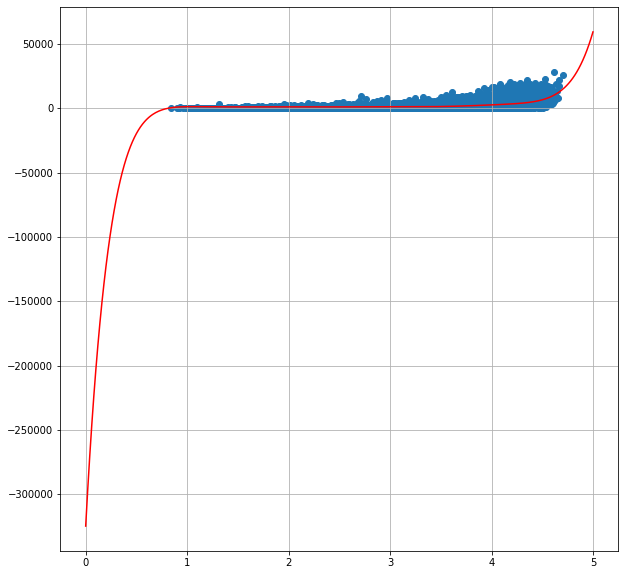

In [22]:
m = 10
O = MNK(data, m)

print("O = {}".format(O))
print("R = {}".format(R(data, O)))
graphic(data, O)

# Проверка гипотезы

In [23]:
def S(X):
    n = len(X)
    X_ = sum(X) / n
    return sum([(x - X_) ** 2 for x in X]) / (n - 1)

In [24]:
s = S(_E(data, MNK(data, 3)))
s

3032407.3648473057

In [25]:
def f(x):
    return math.exp( - x * x / (2 * s * s)) / (s * math.sqrt(2 * math.pi))

def F(x):
    return stats.norm.cdf(x, loc=0, scale=s)

## Хи-квадрат

In [26]:
def X_2(X, f, k=30):
    X = np.array(X)
    h = (max(X) - min(X)) / k
    z = np.arange(min(X), max(X) + h, h)
    n = [sum(sum([(X >= z[j - 1]) & (X <= z[j])])) for j in range(1, len(z))]
    p = [integrate.quad(f, z[j - 1], z[j])[0] for j in range(1, len(z))]
    T = len(X) * sum([(n[j] / len(X) - p[j]) ** 2 / p[j] for j in range(len(p))])
    if T > 17.70837:
        return 1
    return 0

In [27]:
e = _E(data, MNK(data, 3))
print("Принимается H{}".format(X_2(e, f=f)))

Принимается H1


### Выборочная плотность вероятности ошибок

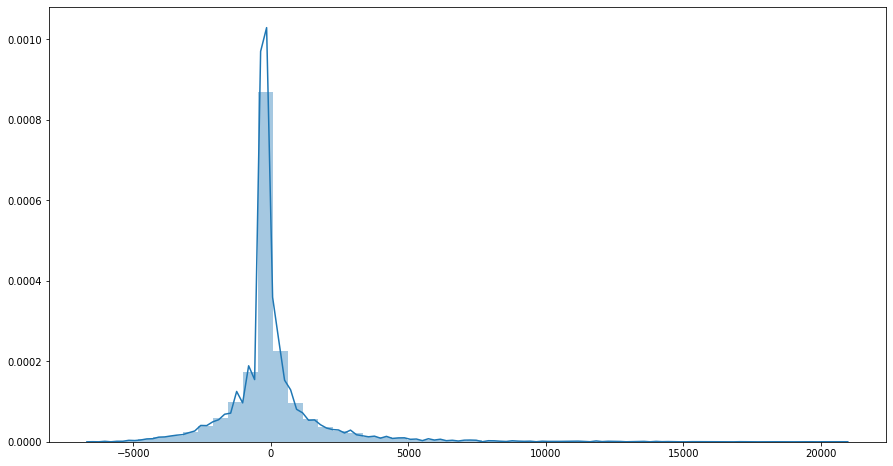

In [28]:
snsplot = plt.figure(figsize=(15, 8))
sns.distplot(e)

### Плотность вероятности распределения

In [29]:
x = np.arange(-50000000, 50000000, 100)

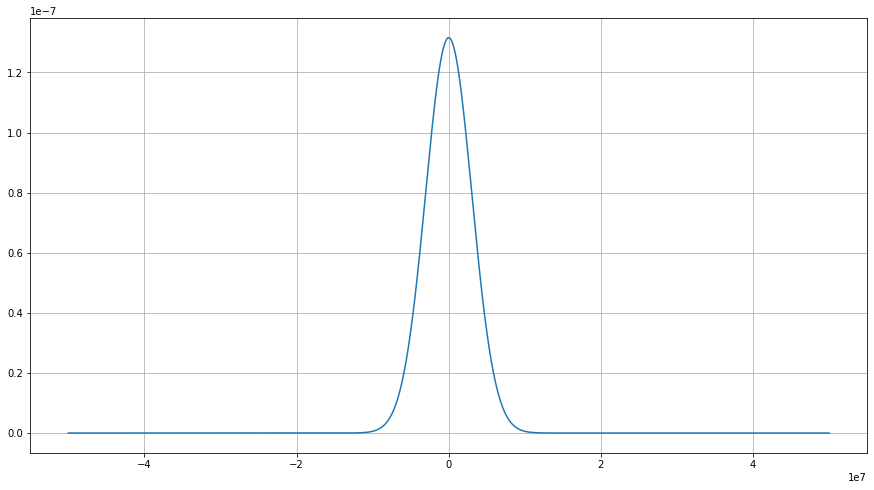

In [30]:
fig = plt.figure(figsize=(15, 8))
plt.grid()
plt.plot(x, stats.norm.pdf(x, 0, s))
plt.show()

## Критерий Колмогорова

In [31]:
def sort_by_key(inp):
    return inp[0]

def Kolmogorov(X, F):
    X = np.array(X)
    n = len(X)
    _F = [np.array([x, sum(sum([X <= x])) / n]) for x in X]
    _F.sort(key=sort_by_key)
    _F = np.array(_F)
    x = []
    for x_ in _F[:, 0]:
        x.append(x_)
        x.append(x_)
    y = []
    for i, y_ in enumerate(_F[:, 1]):
        if i == 0:
            y.append(0.)
        elif i == n - 1:
            y.append(1.)
        else:
            y.append(_F[:, 1][i - 1])
        y.append(y_)
    x = np.array(x)
    y = np.array(y)
    yF = np.array([F(x_) for x_ in x])
    D = abs(yF - y).max()
    T = math.sqrt(n) * D
    K = math.sqrt(- 0.5 * math.log(0.05 / 2))
    if T > K:
        return 1, x, y    
    return 0, x, y

In [32]:
ans, x_, y_ = Kolmogorov(e, F=F)

In [33]:
print("Принимается H{}".format(ans))

Принимается H1


### Выборочная функция распределения

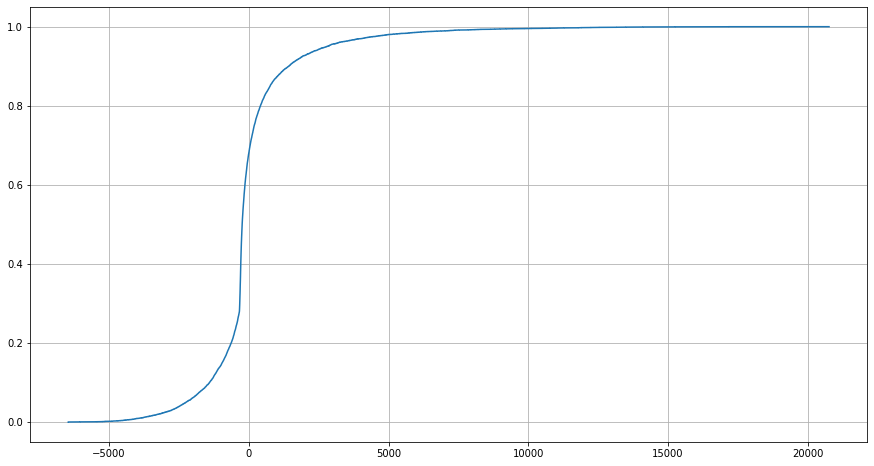

In [34]:
fig = plt.figure(figsize=(15, 8))
plt.grid()
plt.plot(x_, y_)

### Функция распределеня

In [35]:
x = np.arange(-50000000, 50000000, 1000)
y = np.array([F(x_) for x_ in x])

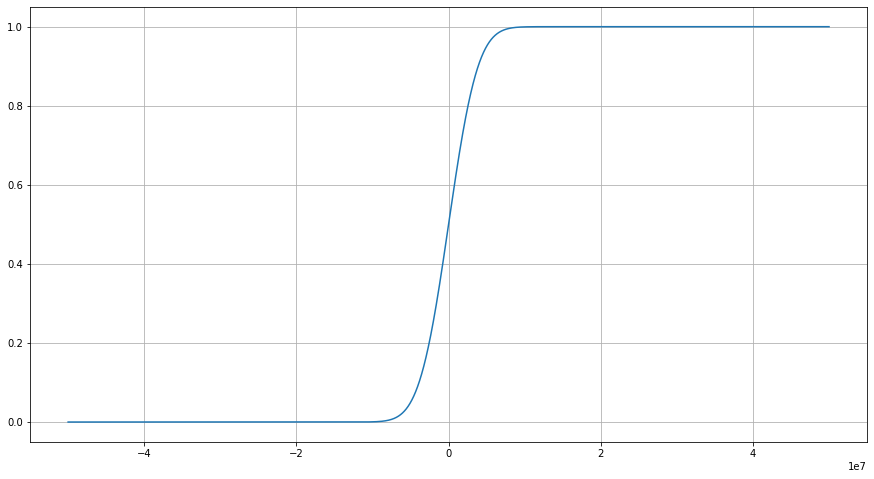

In [36]:
fig = plt.figure(figsize=(15, 8))
plt.grid()
plt.plot(x, y)

# Выбросы

In [37]:
delta = data['wantWatch'].max() - MNK(data, 0)[0]
delta

27337.879656397126

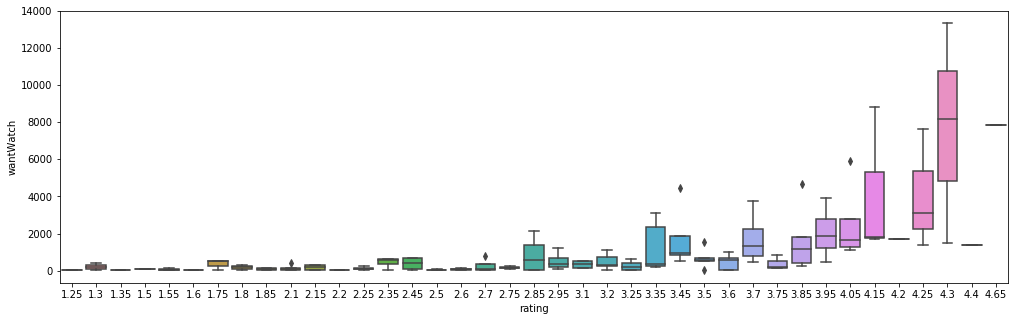

In [38]:
fig = plt.figure(figsize=(17, 5))
sns.boxplot(y='wantWatch', x='rating', data=data[data.rating.isin(np.arange(0, 5, 0.05))])

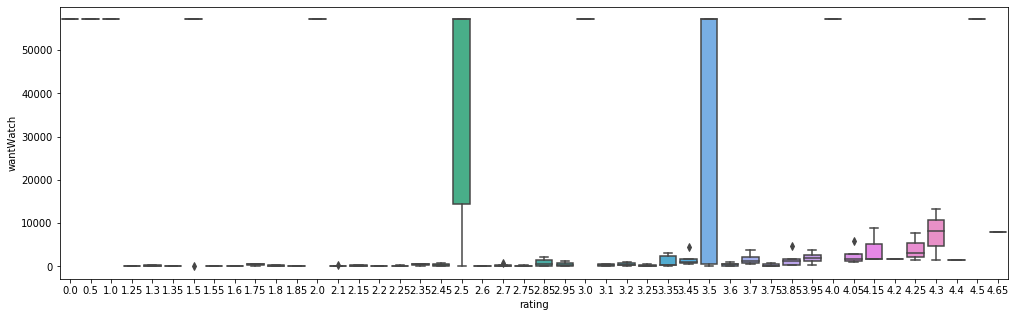

In [39]:
r = np.arange(0, 5.5, 0.5)
v = data['wantWatch'].max() * 2
d = data.copy(deep=True)
for i in range(100):
    k = random.randint(0, len(r) - 1)
    df = pd.DataFrame({"wantWatch": [v], "rating": [r[k]]})
    d = d.append(df)

fig = plt.figure(figsize=(17, 5))
sns.boxplot(y='wantWatch', x='rating', data=d[d.rating.isin(np.arange(0, 5, 0.05))])

## МНК

O = [ 25858.91538854 -23955.78158306   6575.67404942   -482.91321675]
R = 0.16083914015700274


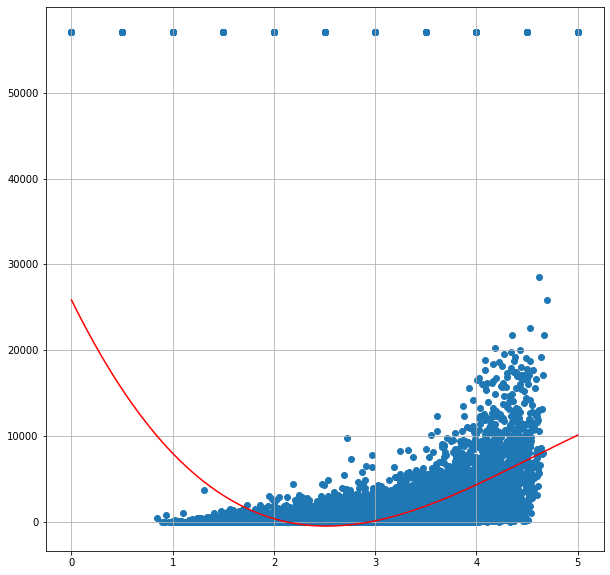

In [40]:
m = 3
O = MNK(d, m)

print("O = {}".format(O))
print("R = {}".format(R(d, O)))
graphic(d, O)

## Хьюбер

In [41]:
def Huber(u, delta=delta / 2):
    if abs(u) < delta:
        return u * u / 2
    return delta * (abs(u) - delta / 2)

def R_H(O, data=d):
    return sum([Huber(e) for e in _E(data, O)])

In [42]:
huber = minimize(R_H, O, method='nelder-mead',
    options={'xtol': 1e-8, 'disp': True})
print(huber.x)

Optimization terminated successfully.
         Current function value: 83285672360.251083
         Iterations: 303
         Function evaluations: 582
[ 6041.22523782 -4013.30030158   281.24283886   141.23099487]


R = 0.12712005555351524


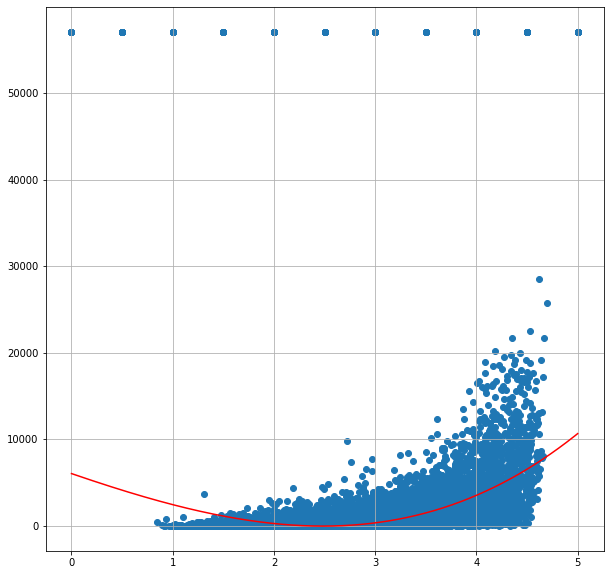

In [43]:
print("R = {}".format(R(d, huber.x)))
graphic(d, huber.x)

## Тьюки

In [44]:
def Tukey(u, delta=delta / 2):
    if abs(u) < delta:
        return 1 - (1 - (u / delta) ** 2) ** 3
    return 1

def R_T(O, data=d):
    return sum([Tukey(e) for e in _E(data, O)])

In [45]:
tukey = minimize(R_T, O, method='nelder-mead',
    options={'xtol': 1e-8, 'disp': True})
print(tukey.x)

Optimization terminated successfully.
         Current function value: 531.111289
         Iterations: 300
         Function evaluations: 566
[-4126.31939213  5877.04764795 -2639.92955291   398.80148389]


R = 0.06997459335249978


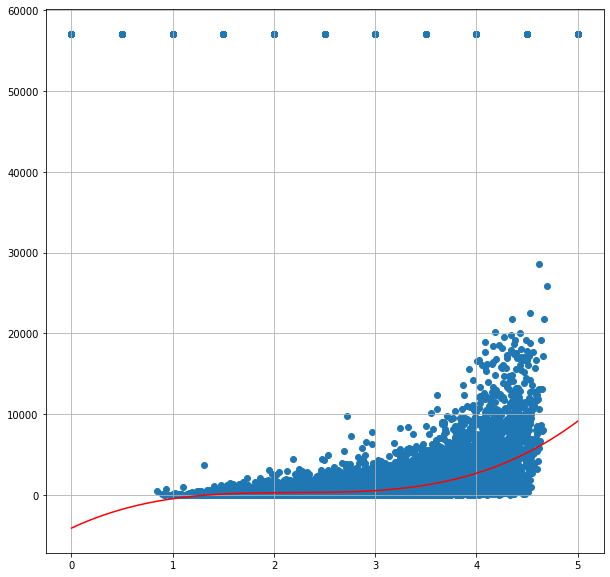

In [46]:
print("R = {}".format(R(d, tukey.x)))
graphic(d, tukey.x)